In [48]:
library(R6)
library(ggplot2)

square <- R6Class("Square",
                  public = list(
                    side = NULL,
                    area = NULL,
                    coordinates = NULL,
                    center = NULL,
                    rotate_times = NULL,
                    width = NULL,
                    length = NULL,
                    initialize = function(side) {
                      self$side <- side
                      self$width <- side
                      self$length <- side
                      self$coordinates <- self$calc_coordinates()
                      self$center <- self$calc_center()
                      self$area <- side * side
                      self$rotate_times <- 1
                    },
                    set_side = function(val) {
                      self$side <- val
                      self$coordinates <- self$calc_coordinates()
                    },
                    calc_coordinates = function() {
                      points <- list()
                      points$p1 <- list(x = 0, y = 0)
                      points$p2 <- list(x = 0, y = self$side)
                      points$p3 <- list(x = self$side, y = 0)
                      points$p4 <- list(x = self$side, y = self$side)
                      points
                    },
                    calc_center = function() {
                      point <- list(
                        x = (self$coordinates$p1$x + self$coordinates$p4$x) / 2,
                        y = (self$coordinates$p1$y + self$coordinates$p4$y) / 2
                      )
                      point
                    },
                    add_x = function(x0) {
                      for (i in 1:length(self$coordinates)) {
                        self$coordinates[[i]][[1]] <- self$coordinates[[i]][[1]] + x0
                      }
                      self$center <- self$calc_center()
                      self
                    },
                    add_y = function(y0) {
                      for (i in 1:length(self$coordinates)) {
                        self$coordinates[[i]][[2]] <- self$coordinates[[i]][[2]] + y0
                      }
                      self$center <- self$calc_center()
                      self
                    },
                    add_xy = function(x0, y0) {
                      self$center <- self$add_x(x0)
                      self$center <- self$add_y(y0)
                      self$center <- self$calc_center()
                      self
                    }
                  )
)

In [49]:
s1 <- square$new(side = 3)
s1$coordinates$p1$x
s1$side
s1$area
s1$center$x

[1] 0

[1] 3

[1] 9

[1] 1.5

In [50]:
s1$add_x(x0 = 2)$add_xy(x0 = 1, y0 = 2)
print(s1$coordinates)

<Square>
  Public:
    add_x: function (x0) 
    add_xy: function (x0, y0) 
    add_y: function (y0) 
    area: 9
    calc_center: function () 
    calc_coordinates: function () 
    center: list
    clone: function (deep = FALSE) 
    coordinates: list
    initialize: function (side) 
    length: 3
    rotate_times: 1
    set_side: function (val) 
    side: 3
    width: 3

$p1
$p1$x
[1] 3

$p1$y
[1] 2


$p2
$p2$x
[1] 3

$p2$y
[1] 5


$p3
$p3$x
[1] 6

$p3$y
[1] 2


$p4
$p4$x
[1] 6

$p4$y
[1] 5




In [51]:
check_bounds <- function(sq, frame, x, y, len, width){
  out <- TRUE
  
  for (cellx in 1:len){
    for (celly in 1:width) {
      if (out){
        y0 = celly + y - 1
        x0 = cellx + x - 1
        
        if (frame[x0, y0] != 0){
            out <- FALSE
          }
      }
    }
  }
  
  return(out)
  
}

In [52]:
square_canvas <- R6Class(
    "SquareCanvas",
    public = list(
      max_bound = NULL,
      contents = NULL,
      frame_override = NULL,
      validate = NULL,
      rotation = NULL,
      frame=NULL,
      x_max=NULL,
      x_min=NULL,
      y_max=NULL,
      y_min=NULL
      ,
      initialize = function(
        max_bound = 10,
        contents = list(),
        frame_override = NULL,
        validate = TRUE,
        allow_rotation = FALSE
      ) {
        self$max_bound <- max_bound
        
        if (is.null(frame_override)){
          self$frame <- matrix(0, self$max_bound, self$max_bound)
        } else {
          self$frame <- frame_override
        }
        
        self$x_max <- dim(self$frame)[1]
        self$y_max <- dim(self$frame)[2]
        self$x_min <- 0
        self$y_min <- 0
        
        self$rotation <- allow_rotation
        # sorted contents?
        
        for (sq in contents) {
          self$add_contents(sq)
        }
        
        if (validate) {
          self$check_all_filled(contents)
        }
        
      },
      add_contents = function(sq){
        placed <- FALSE
        max_rotate <- ifelse(self$rotation, sq$rotate_times, 1)
        for (rot in 1:max_rotate) {
          if (!placed) {
            if((class(square$new(6)) != "Square")[1]){
              sq$rotate(90 * rot)
            }
            
            len <- sq$width
            width <- sq$length
            for (x in 1:nrow(self$frame)) {
              for (y in 1:ncol(self$frame)) {
                if (
                  (!placed) &
                  (self$frame[x, y] == 0) &
                  !(((x + len + 1) >= self$x_max) & ((x + len) > 0)) &
                  !(((y + width + 1) >= self$y_max) & ((y + width < 0)))
                ) {
                  fit <- check_bounds(sq, self$frame, x, y, len, width)

                  if (fit) {
                    self$contents <- c(self$contents, sq)
                    sq$add_xy(x, y)
                    placed <- TRUE
                    for (cellx in 1:len) {
                      for (celly in 1:width) {
                        y0 <- celly + y - 1
                        x0 <- cellx + x - 1
                        self$frame[x0, y0] <- length(self$contents)
                      }
                    }
                  }
                }
              }
            }
          }
        }
        # if not placed:
        #   raise IndexError("Not all placed...")
      },
      x_list = function() {
        return(
          sapply(self$contents,
                 function(x) {
                   x$center[1]
                 }))
      },
      y_list = function() {
        return(
          sapply(self$contents,
                 function(x) {
                   x$center[2]
                 }))
      },
      center_list = function() {
        return(
          sapply(self$contents,
                 function(x) {
                   x$center
                 }))
      },
      generate_ggplot = function(
        show_text = TRUE,
        palette = NULL
      ) {
        coords <- sapply(self$contents, function(x) { x})
        x_min <- sapply(coords, function(x) { x$coordinates$p1$x - 1})
        x_max <- sapply(coords, function(x) { x$coordinates$p4$x - 1})
        y_min <- sapply(coords, function(x) { x$coordinates$p1$y - 1})
        y_max <- sapply(coords, function(x) { x$coordinates$p4$y - 1})
        
        df <- data.frame(
          x_min = x_min,
          x_max = x_max,
          y_min = y_min,
          y_max = y_max
        )
        
        pl <- ggplot(df) + xlim(self$x_min, self$x_max) + ylim(self$y_min, self$y_max)

        pl <- pl + geom_rect(xmin=x_min, ymin=y_min, xmax=x_max, ymax=y_max, fill="blue")
        return(pl)
        
      },
      check_all_filled = function(val) {
        
      }
    ))

In [53]:
  A <- square_canvas$new(contents = c(square$new(6), square$new(4)))

In [54]:
A$frame

1,1,1,1,1,1,2,2,2,2
1,1,1,1,1,1,2,2,2,2
1,1,1,1,1,1,2,2,2,2
1,1,1,1,1,1,2,2,2,2
1,1,1,1,1,1,0,0,0,0
1,1,1,1,1,1,0,0,0,0
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0


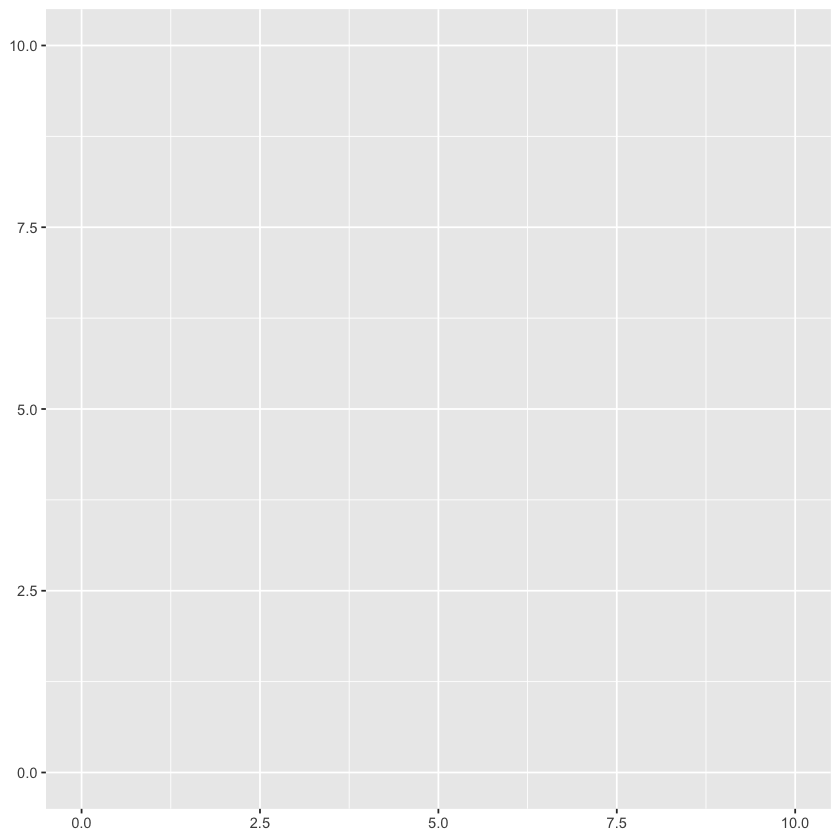

In [55]:
A$generate_ggplot()